# 分块图像处理,快速概览

在本笔记本中,我们将处理一个以zarr格式保存的大型数据集,使用[dask](https://docs.dask.org/en/stable/)和[zarr](https://zarr.readthedocs.io/en/stable/)来计算单个块中的细胞数量。下一节将解释基本原理。

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

为了演示目的,我们使用由德累斯顿工业大学卡尔·古斯塔夫·卡鲁斯大学医院OncoRay的Theresa Suckert提供的数据集。该数据集采用[CC-BY 4.0许可](https://creativecommons.org/licenses/by/4.0/)。我们在这里使用了一个裁剪版本,并重新保存为8位图像,以便随笔记本一起提供。你可以在[在线](https://zenodo.org/record/4276076#.YX1F-55BxaQ)找到完整大小的16位CZI格式图像。生物学背景在[Suckert et al. 2020](https://www.sciencedirect.com/science/article/abs/pii/S0167814020301043)中有解释,我们在那里也应用了类似的工作流程。

在处理大数据时,你可能一开始就有一个以正确格式存储的图像。为了演示目的,我们在这里将测试图像保存为zarr格式,这种格式通常用于处理大型图像数据。

In [2]:
# Resave a test image into tiled zarr format
input_filename = '../../data/P1_H_C3H_M004_17-cropped.tif'
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
image = imread(input_filename)[1]
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
zarray = zarr.array(image, chunks=(100, 100), compressor=compressor)
zarr.convenience.save(zarr_filename, zarray)

## 加载zarr格式的图像
Dask内置支持zarr文件格式。我们可以直接从zarr文件创建dask数组。

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(2000, 5000), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

我们可以直接对这个分块数据集进行图像处理。

## 计数细胞核
为了计数细胞核,我们设置了一个简单的图像处理工作流程。它返回一个图像,其中包含一个单像素,表示给定输入图像中的细胞核数量。这些单个像素将组装成一个像素计数图;一个比原始图像像素少得多的图像,但优点是我们可以查看它 - 它不再是大数据了。cle.exclude_labels_with_map_values_within_range

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    label_intensity_map = cle.mean_intensity_map(image, labels)
    
    high_intensity_labels = cle.exclude_labels_with_map_values_within_range(label_intensity_map, labels, maximum_value_range=20)
    nuclei_count = high_intensity_labels.max()
    
    # Count nuclei including those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(high_intensity_labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    return result

在开始计算之前,我们需要禁用pyclesperanto中操作的异步执行。[另请参阅相关问题](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163)。

In [5]:
cle.set_wait_for_kernel_finish(True)

为了使用dask处理块,我们设置了无重叠的处理块。

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)

tile_map

dask.array<count_nuclei, shape=(2000, 5000), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

由于结果图像比原始图像小得多,我们可以计算整个结果图。

In [7]:
result = tile_map.compute()

In [8]:
result.shape

(20, 50)

同样,由于结果图很小,我们可以直接可视化它。

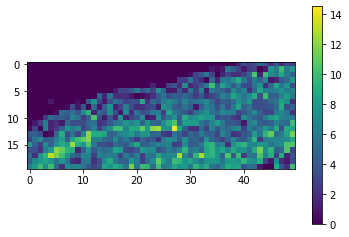

In [9]:
cle.imshow(result, colorbar=True)

通过对原始图像进行快速目视检查,我们可以看到,在图像的左上角确实比右下角的细胞少得多。

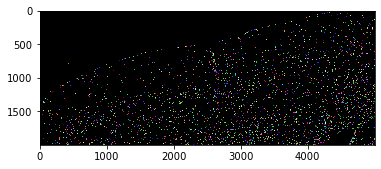

In [10]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)